In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import graphviz
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import warnings
warnings.filterwarnings('ignore')

In [77]:
# To use 한글 font in graphs
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

ds_hmeq = pd.read_csv("./csvfiles/HMEQ.csv")

ds_hmeq.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [78]:
ds_hmeq["JOB"].fillna("Other", inplace = True)
ds_hmeq.fillna(ds_hmeq.mean(), inplace = True)

ds_hmeq_dummy = pd.get_dummies(ds_hmeq)
ds_hmeq_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [79]:
np.random.seed(seed = 1234)
msk = np.random.rand(ds_hmeq_dummy.shape[0]) < 0.7
ds_hmeq_train = ds_hmeq_dummy[msk]
ds_hmeq_test = ds_hmeq_dummy[~msk]

ds_hmeq_train_y = ds_hmeq_train["BAD"]
ds_hmeq_train_x = ds_hmeq_train.drop("BAD", axis = 1)
ds_hmeq_test_y = ds_hmeq_test["BAD"]
ds_hmeq_test_x = ds_hmeq_test.drop("BAD", axis = 1)

print("train data X size:", ds_hmeq_train_x.shape)
print("train data y size:", ds_hmeq_train_y.shape)
print("test data X size:", ds_hmeq_test_x.shape)
print("test data y size:", ds_hmeq_test_y.shape)



train data X size: (2604, 18)
train data y size: (2604,)
test data X size: (1144, 18)
test data y size: (1144,)


In [80]:
rf_uncustom = RandomForestClassifier(random_state=1234, )
rf_uncustom.fit(ds_hmeq_train_x, ds_hmeq_train_y)
# 훈련 데이터 정확도
print("Accuray on training set:{:.3f}".format(rf_uncustom.score(ds_hmeq_train_x, ds_hmeq_train_y)))

# test 데이터 정확도
print("Accuray on test set:{:.3f}".format(rf_uncustom.score(ds_hmeq_test_x, ds_hmeq_test_y)))

Accuray on training set:0.992
Accuray on test set:0.948


In [81]:
#train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []

# 트리수 최대값 : 30 ;1~30까지 실행
n_iter_tree = 30

# para_criterion 별로 트리 모델 생성 및 정확도 값 저장
for n_tree in range(n_iter_tree):
    tree1 = RandomForestClassifier(n_estimators=n_tree+1, random_state=1234)
    tree1.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(tree1.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(tree1.score(ds_hmeq_test_x, ds_hmeq_test_y))
    
#저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성

ds_accuracy1 = pd.DataFrame()
ds_accuracy1["NumberofTree"] = [n_tree+1 for n_tree in range(n_iter_tree)]
ds_accuracy1["TrainAccuracy"] = train_accuracy
ds_accuracy1["TestAccuracy"] = test_accuracy
ds_accuracy1.round(3)


,NumberofTree,TrainAccuracy,TestAccuracy
0,1,0.970,0.931
1,2,0.969,0.939
2,3,0.988,0.941
3,4,0.981,0.946
4,5,0.991,0.945
5,6,0.986,0.947
6,7,0.993,0.949
7,8,0.989,0.947
8,9,0.995,0.949
9,10,0.992,0.948


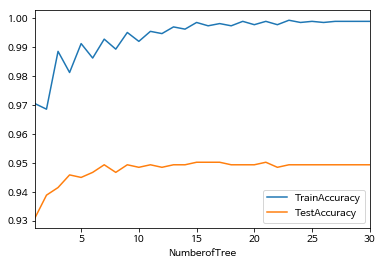

In [82]:
ds_accuracy1.set_index("NumberofTree", inplace=False).plot.line()

In [83]:


#train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []

# 적용가능한 criterion : gini, entropy
para_criterion = ['gini', 'entropy']

# para_criterion 별로 트리 모델 생성 및 정확도 값 저장
for criterion in para_criterion:
    rf2 = DecisionTreeClassifier(criterion = criterion, random_state=1234)
    rf2.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(rf2.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(rf2.score(ds_hmeq_test_x, ds_hmeq_test_y))
    
#저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성

ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2.round(3)


,Criterion,TrainAccuracy,TestAccuracy
0,gini,1.0,0.927
1,entropy,1.0,0.921


In [84]:
#train 및 test 정확도 결과 저장용
train_accuracy =[]
test_accuracy = []

#최대 깊이 1~10까지 순차 실행
n_iter_depth = 10

#parameter 결과 테이블을 위해
para_criterion = ["gini"] * n_iter_depth + ["entropy"] * n_iter_depth
para_max_depth = [i+1 for i in range(10)] * 2


for (criterion, depth) in zip(para_criterion, para_max_depth):
    rf3 = RandomForestClassifier(criterion=criterion, max_depth=depth, random_state=1234)
    rf3.fit(ds_hmeq_train_x, ds_hmeq_train_y)

    train_accuracy.append(rf3.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(rf3.score(ds_hmeq_test_x, ds_hmeq_test_y))
        


In [85]:
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["test_accuracy"] = test_accuracy
ds_accuracy3.round(3)

,Criterion,Depth,TrainAccuracy,test_accuracy
0,gini,1,0.909,0.911
1,gini,2,0.914,0.919
2,gini,3,0.932,0.932
3,gini,4,0.934,0.934
4,gini,5,0.938,0.937
5,gini,6,0.940,0.938
6,gini,7,0.944,0.939
7,gini,8,0.947,0.936
8,gini,9,0.948,0.940
9,gini,10,0.953,0.942


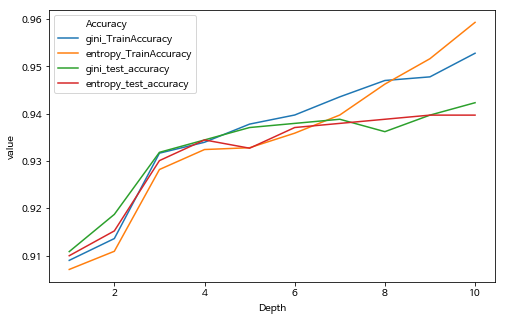

In [86]:
plt.figure(figsize=(8,5))
ds_accuracy3_melt = pd.melt(ds_accuracy3, id_vars=["Criterion", 'Depth'])
ds_accuracy3_melt["Accuracy"] = ds_accuracy3_melt["Criterion"] + "_" + ds_accuracy3_melt["variable"]
sns.lineplot(x="Depth", y="value", hue="Accuracy", data=ds_accuracy3_melt)

In [87]:
#train 및 test 정확도 결과 저장용
train_accuracy =[]
test_accuracy = []

#최대 깊이 4
n_depth = 4

# 최소 잎사귀 수 10까지 순차 실행
n_iter_min_leaf_size = 10
para_criterion = ["gini"] * n_iter_min_leaf_size
para_min_leaf_size = [i+1 for i in range(n_iter_min_leaf_size)]

# criterion : gini, entropy & max_depth : 1~10까지 & min_sample_szie: 1~10까지 반복 실행


for (criterion, leafsize) in zip(para_criterion, para_min_leaf_size):
    rf4 = RandomForestClassifier(criterion=criterion, max_depth=n_depth, min_samples_leaf=leafsize, random_state=1234)
    rf4.fit(ds_hmeq_train_x, ds_hmeq_train_y)

    train_accuracy.append(rf4.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(rf4.score(ds_hmeq_test_x, ds_hmeq_test_y))
        
ds_accuracy4 = pd.DataFrame()
ds_accuracy4["Criterion"] = para_criterion
ds_accuracy4["Depth"] = n_depth
ds_accuracy4["MinLeafSize"] = para_min_leaf_size
ds_accuracy4["TrainAccuracy"] = train_accuracy
ds_accuracy4["test_accuracy"] = test_accuracy
ds_accuracy4.round(3)

,Criterion,Depth,MinLeafSize,TrainAccuracy,test_accuracy
0,gini,4,1,0.934,0.934
1,gini,4,2,0.934,0.935
2,gini,4,3,0.934,0.935
3,gini,4,4,0.933,0.934
4,gini,4,5,0.933,0.934
5,gini,4,6,0.932,0.935
6,gini,4,7,0.930,0.935
7,gini,4,8,0.930,0.934
8,gini,4,9,0.930,0.933
9,gini,4,10,0.929,0.932


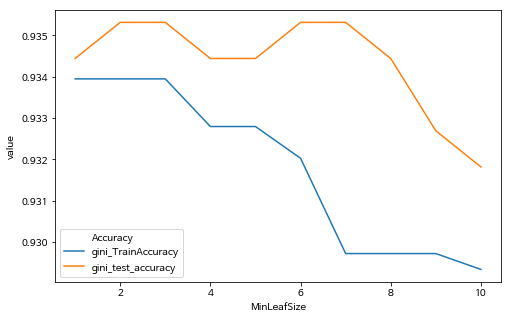

In [88]:
plt.figure(figsize=(8,5))
ds_accuracy4_melt = pd.melt(ds_accuracy4, id_vars=["Criterion", 'Depth','MinLeafSize'])
ds_accuracy4_melt["Accuracy"] = ds_accuracy4_melt["Criterion"] + "_" + ds_accuracy4_melt["variable"]
sns.lineplot(x="MinLeafSize", y="value", hue="Accuracy", data=ds_accuracy4_melt)

In [94]:
ds_hmeq_train_x =ds_hmeq_train_x.drop('JOB_Self', axis = 1)
rf_model = RandomForestClassifier(criterion='gini', max_depth=4, min_samples_leaf=10, n_estimators=100,
                                 random_state=1234)
rf_model.fit(ds_hmeq_train_x,ds_hmeq_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [95]:
rf4.score(ds_hmeq_test_x, ds_hmeq_test_y)

0.9318181818181818

In [96]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = ds_hmeq_train_x.columns
ds_feature_importance["Importance"] = rf_model.feature_importances_
#ds_feature_importance의 테이블을 중요도별로 정렬
ds_feature_importance=ds_feature_importance.sort_values("Importance", ascending=False)
ds_feature_importance.round(3)

,Feature,Importance
9,DEBTINC,0.465
5,DELINQ,0.157
4,DEROG,0.118
6,CLAGE,0.059
8,CLNO,0.050
7,NINQ,0.048
2,VALUE,0.027
0,LOAN,0.025
1,MORTDUE,0.021
3,YOJ,0.016


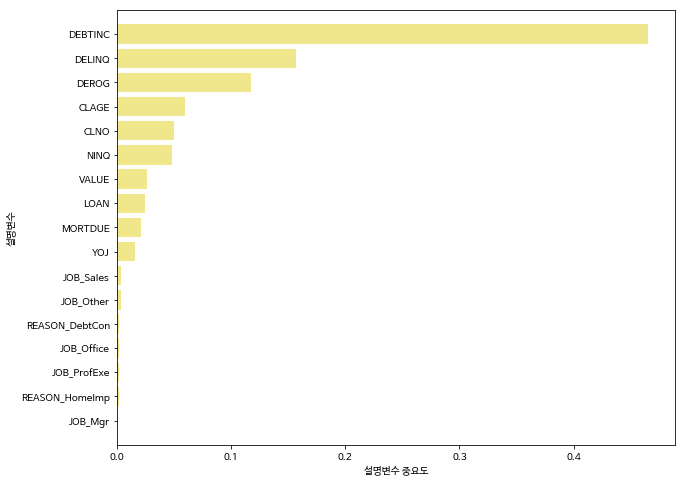

In [97]:
def plot_feature_importances(model):
    cols = ds_hmeq_train_x.columns
    importances = model.feature_importances_
    indices = np.argsort(model.feature_importances_)
    plt.barh(range(len(indices)), importances[indices], align="center", color='khaki')
    plt.yticks(range(len(indices)), [cols[i] for i in indices])
    plt.xlabel("설명변수 중요도")
    plt.ylabel('설명변수')
    plt.ylim(-1, len(cols))

# 설명 변수 중요도 그래프 함수 실행
plt.figure(figsize=(10,8))
plot_feature_importances(rf_model)